In [1]:
setwd("..")

In [2]:
source("Source/functions.R")

In [3]:
library("data.table")
library("DESeq2")
library("ggplot2")
library("ggrepel")
library("grid")
library("gridExtra")
library("VennDiagram")
library("clusterProfiler")
library("RColorBrewer")
library("UpSetR")
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:data.table’:

    first, second

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges

Attaching package: 

In [4]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

In [5]:
SampleInfo <- fread("Data/SampleInfo.csv")

sampleIDs <- SampleInfo[, SampleID]
SampleInfo[, Type := factor(SampleInfo[, Type], levels = c("N", "S", "M", "T"))]
SampleInfo[, IsResponsive := factor(ifelse(SampleInfo[, Type] == "N", "N", "Y"), levels = c("N", "Y"))]

sampleGroups <- c("N", "S", "M", "T")

groupColors <- c(N = "#888888", 
                 S = rgb(red = 0, green = 128/255, blue = 225/255),
                 M = rgb(red = 255/255, green = 255/255, blue = 0), 
                 T = rgb(red = 255/255, green = 0, blue = 255/255)
)

sampleColors <- groupColors[SampleInfo[J(sampleIDs), as.character(Type), on = "SampleID"]]
names(sampleColors) <- sampleIDs

In [6]:
cnts_exon <- read.csv("Data/cnts_exon.csv.gz", row.names = 1, as.is = TRUE)

### 1. R (S, M, T) vs. NR (N)

In [7]:
eset_exon <- DESeqDataSetFromMatrix(countData = cnts_exon, colData = SampleInfo, design = ~ IsResponsive)
eset_exon <- estimateSizeFactors(eset_exon)
exprs_exon <- log2(1 + counts(eset_exon, normalized = TRUE))

In [8]:
write.csv(exprs_exon, file = gzfile("Result/exprs_exon.csv.gz"))

In [9]:
cells_exon_pergene <- rowSums(counts(eset_exon) > 0)
idx <- cells_exon_pergene >= 5
eset_exon <- eset_exon[idx, ]
eset_exon <- DESeq(eset_exon)
DE_exon <- NULL
DE_exon$R_vs_N <- results(eset_exon, contrast = c("IsResponsive", "Y", "N"))
DE_exon_pvals <- data.frame(R_vs_N = DE_exon$R_vs_N$pvalue)
DE_exon_pvals_df <- melt(DE_exon_pvals, variable.name = "contrast", value.name = "pvalue")

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 3294 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message in melt.default(DE_exon_pvals, variable.name = "contrast", value.name = "pvalue"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(DE_exon_pvals). In the next version, this warning will become an error.”
No id variables; using all as measure variables


Warning message:
“Removed 1611 rows containing non-finite outside the scale range (`stat_bin()`).”


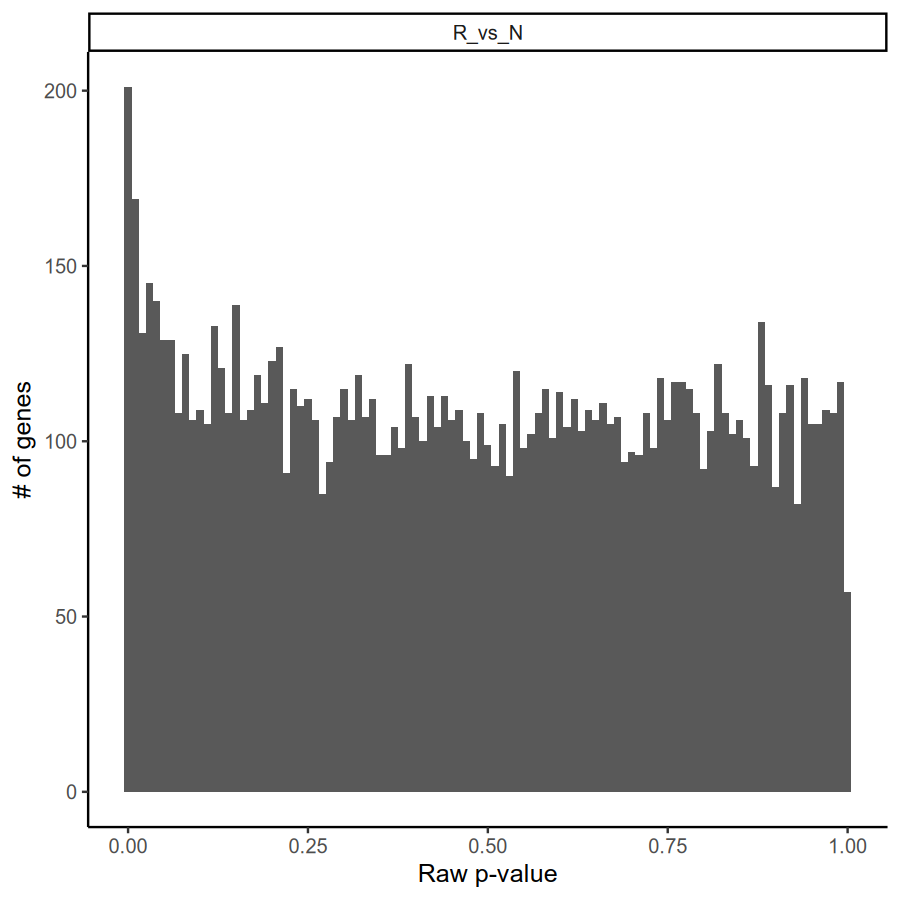

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
ggplot(DE_exon_pvals_df, aes(x = pvalue)) + geom_histogram(binwidth = 0.01) + facet_grid(~contrast) + xlab("Raw p-value") + ylab("# of genes") + theme_classic(base_size = 12)

In [11]:
cmps <- c("R_vs_N")
DE_tables_exon <- sapply(cmps, function(x) {
    X <- DE_exon[[x]]
    X <- X[order(X$padj), ]
    genes <- rownames(X)
    SIDs <- c(SampleInfo[IsResponsive == "N", SampleID], SampleInfo[IsResponsive == "Y", SampleID])
    cnts <- cnts_exon[genes, SIDs]; colnames(cnts) <- paste0("RawCnts_", SampleInfo[SIDs, Type, on = "SampleID"], "_", SIDs) 
    exprs <- exprs_exon[genes, SIDs]; colnames(exprs) <- paste0("LogNorm_", SampleInfo[SIDs, Type, on = "SampleID"], "_", SIDs)
    Y <- as.data.frame(X[genes, ])
    data.table(Symbol = genes, Contrast = x, cnts, exprs, Y)
}, simplify = FALSE)

In [12]:
DE_tables_exon$R_vs_N[1:5, ]

Symbol,Contrast,RawCnts_N_J182_2,RawCnts_N_J183_1,RawCnts_N_J185_4,RawCnts_N_J186_5,RawCnts_N_J187_6,RawCnts_S_J150_3,RawCnts_S_J151_5,RawCnts_S_J153_6,⋯,LogNorm_M_J173_25,LogNorm_M_J174_13,LogNorm_M_J175_18,LogNorm_M_J176_25,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A730020E08Rik,R_vs_N,0,0,0,0,0,0,3,6,⋯,1.263282,0.5546631,7.319650,0.000000,76.58253,23.01126,2.384539,9.650193,4.906325e-22,5.231614e-18
4930563E22Rik,R_vs_N,0,0,0,0,0,0,1,17,⋯,0.000000,7.8587955,2.040085,5.911386,24.34401,20.46497,2.425359,8.437911,3.230600e-17,1.722395e-13
Mrvi1,R_vs_N,0,0,0,0,0,0,100,406,⋯,10.687013,5.2314476,0.000000,6.058914,21.75736,21.65665,2.684046,8.068657,7.107544e-16,2.526258e-12
Ccdc103,R_vs_N,0,0,0,0,0,2224,0,31,⋯,6.728341,2.6222467,0.000000,3.803301,20.46544,19.00615,2.561045,7.421246,1.160235e-13,3.092896e-10
Dscc1,R_vs_N,0,0,0,0,0,1,1008,0,⋯,9.510199,0.0000000,0.000000,0.000000,46.05196,22.89832,3.296350,6.946567,3.742831e-12,7.981961e-09


In [13]:
Tools$write_xlsx(DE_tables_exon, file = "Result/DE_R_vs_N_tables_exon.xlsx", row.names = FALSE)

In [14]:
log2fc_th <- 1
padj_th <- 0.05
DE_exon_pvalfc <- sapply(cmps, function(x) {
    X <- DE_tables_exon[[x]]
    Y <- data.table(
        Symbol = X[, Symbol], 
        log2FoldChange = X[, log2FoldChange], 
        log10padj = -log10(X[, padj]), 
        is_significant = !is.na(X[, padj]) & X[, padj] < padj_th & abs(X[, log2FoldChange]) > log2fc_th
    )
}, simplify = FALSE)

Warning message:
“Removed 2056 rows containing missing values or values outside the scale range (`geom_point()`).”


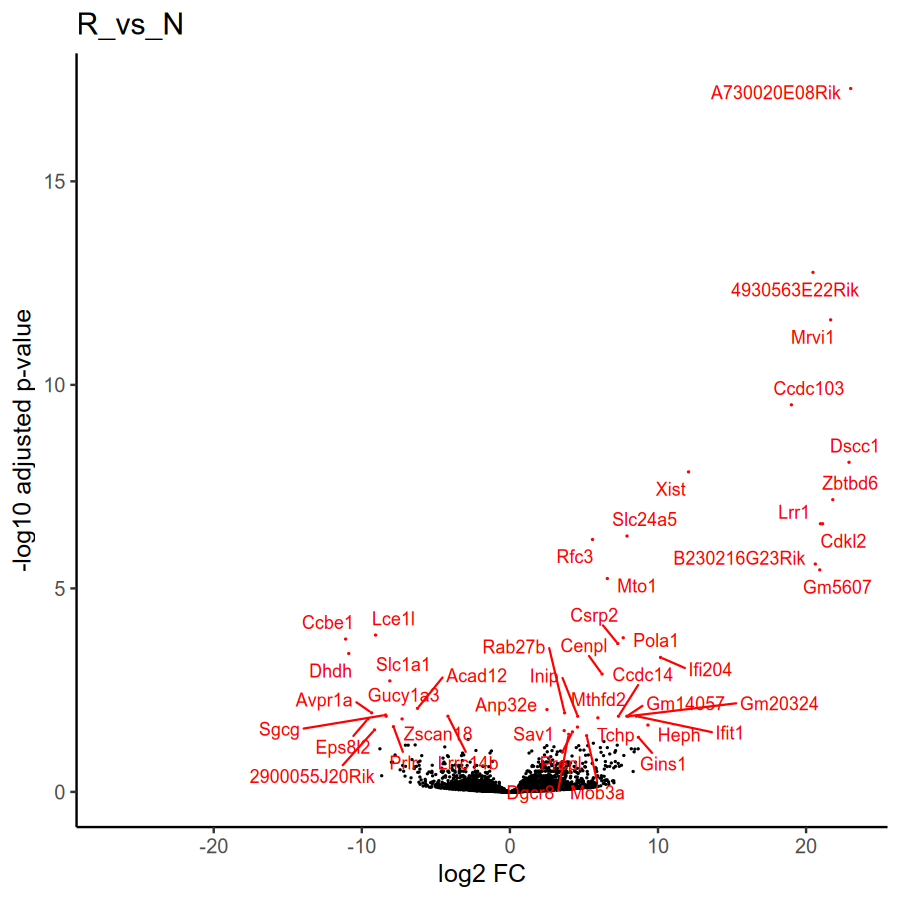

In [15]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
for (cmp in cmps) {
    print(ggplot(DE_exon_pvalfc[[cmp]], aes(x = log2FoldChange, y = log10padj, col = is_significant)) + 
          geom_point(size = 0.1) + xlab("log2 FC") + ylab("-log10 adjusted p-value") + ggtitle(cmp) + theme_classic(base_size = 12) + 
          scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) + guides(color = "none") + 
          geom_text_repel(aes(x = log2FoldChange, y = log10padj, label = DE_exon_pvalfc[[cmp]][is_significant == TRUE, Symbol]), 
          size = 3, max.overlaps = 50, data = DE_exon_pvalfc[[cmp]][is_significant == TRUE]))
}

In [16]:
with(DE_exon_pvalfc[["R_vs_N"]], table(ifelse(log2FoldChange > 0, "up", "dn"), is_significant))

    is_significant
     FALSE TRUE
  dn  6459   13
  up  6214   33

In [17]:
siggenes_exon <- sapply(cmps, function(x) {
    X <- DE_exon_pvalfc[[x]]
    list(
         both = X[is_significant == TRUE, Symbol], 
         up = X[is_significant == TRUE & log2FoldChange > 0, Symbol], 
         dn = X[is_significant == TRUE & log2FoldChange < 0, Symbol]
     )
}, simplify = FALSE)

In [18]:
str(siggenes_exon)

List of 1
 $ R_vs_N:List of 3
  ..$ both: chr [1:46] "A730020E08Rik" "4930563E22Rik" "Mrvi1" "Ccdc103" ...
  ..$ up  : chr [1:33] "A730020E08Rik" "4930563E22Rik" "Mrvi1" "Ccdc103" ...
  ..$ dn  : chr [1:13] "Lce1l" "Ccbe1" "Dhdh" "Slc1a1" ...


In [19]:
Tools$write_xlsx(lapply(siggenes_exon, Tools$list_to_df), file = "Result/DE_R_vs_N_siggenes_exon.xlsx", row.names = FALSE)

In [20]:
GOSymbolList <- readRDS(file = "Data/GO/OrgDb/GOSymbol.2019.RDS")
GOSymbol <- GOSymbolList$mouse
GONameList <- readRDS(file = "Data/GO/OrgDb/GOName.2019.RDS")
GOName <- GONameList$mouse

In [21]:
siggenes_exon_ego <- NULL
for (x in cmps) {
    for (y in c("both", "up", "dn")) {
        for (z in c("MF", "BP", "CC")) {
            message(x, " ", y, " ", z)
            siggenes_exon_ego[[x]][[y]][[z]] <- NULL
            e <- enricher(
                gene = siggenes_exon[[x]][[y]], 
                pvalueCutoff = Inf, 
                qvalueCutoff = Inf, 
                universe = rownames(eset_exon), 
                pAdjustMethod = "BH", 
                minGSSize = 10, maxGSSize = 500, 
                TERM2GENE = GOSymbol[[z]], 
                TERM2NAME = GOName[[z]]
            )
            siggenes_exon_ego[[x]][[y]][[z]] <- as.data.table(e)
        }
    }
}

R_vs_N both MF
R_vs_N both BP
R_vs_N both CC
R_vs_N up MF
R_vs_N up BP
R_vs_N up CC
R_vs_N dn MF
R_vs_N dn BP
R_vs_N dn CC


In [22]:
siggenes_exon_ego_dfs <- NULL
for (x in cmps) {
    for (y in c("both", "up", "dn")) {
        s <- paste0(x, "_", y)
        Y <- rbindlist(lapply(c("MF", "BP", "CC"), function(o) {
            X <- siggenes_exon_ego[[x]][[y]][[o]]
            X[, Category := o]
            X
        }))
        Y <- Y[order(Y$p.adjust), ]
        siggenes_exon_ego_dfs[[s]] <- NULL
        siggenes_exon_ego_dfs[[s]] <- Y
    }
}

In [23]:
filename <- "Result/DE_R_vs_N_siggenes_exon_enrich_GO.xlsx"
Tools$write_xlsx(siggenes_exon_ego_dfs, file = filename, overwrite = TRUE, row.names = FALSE)

### 2. Pairwise comparison

In [24]:
pairwise_eset_exon <- DESeqDataSetFromMatrix(countData = cnts_exon, colData = SampleInfo, design = ~ Type)
pairwise_eset_exon <- estimateSizeFactors(pairwise_eset_exon)
cells_exon_pergene <- rowSums(counts(pairwise_eset_exon) > 0)
idx <- cells_exon_pergene >= 5
pairwise_eset_exon <- pairwise_eset_exon[idx, ]
pairwise_eset_exon <- DESeq(pairwise_eset_exon)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [25]:
pairwise_DE_exon <- NULL
pairwise_DE_exon$T_vs_S <- results(pairwise_eset_exon, contrast = c("Type", "T", "S"))
pairwise_DE_exon$T_vs_M <- results(pairwise_eset_exon, contrast = c("Type", "T", "M"))
pairwise_DE_exon$S_vs_M <- results(pairwise_eset_exon, contrast = c("Type", "S", "M"))
pairwise_DE_exon$S_vs_N <- results(pairwise_eset_exon, contrast = c("Type", "S", "N"))
pairwise_DE_exon$T_vs_N <- results(pairwise_eset_exon, contrast = c("Type", "T", "N"))
pairwise_DE_exon$M_vs_N <- results(pairwise_eset_exon, contrast = c("Type", "M", "N"))

In [26]:
pairwise_cmps <- names(pairwise_DE_exon)

In [27]:
pairwise_DE_exon_pvals <- data.table(
    T_vs_S = pairwise_DE_exon$T_vs_S$pvalue, 
    T_vs_M = pairwise_DE_exon$T_vs_M$pvalue, 
    S_vs_M = pairwise_DE_exon$S_vs_M$pvalue,
    S_vs_N = pairwise_DE_exon$S_vs_N$pvalue, 
    M_vs_N = pairwise_DE_exon$M_vs_N$pvalue, 
    T_vs_N = pairwise_DE_exon$T_vs_N$pvalue
)

pairwise_DE_exon_pvals_df <- melt(pairwise_DE_exon_pvals, measure.vars = pairwise_cmps, variable.name = "contrast", value.name = "pvalue")

Warning message:
“Removed 6396 rows containing non-finite outside the scale range (`stat_bin()`).”


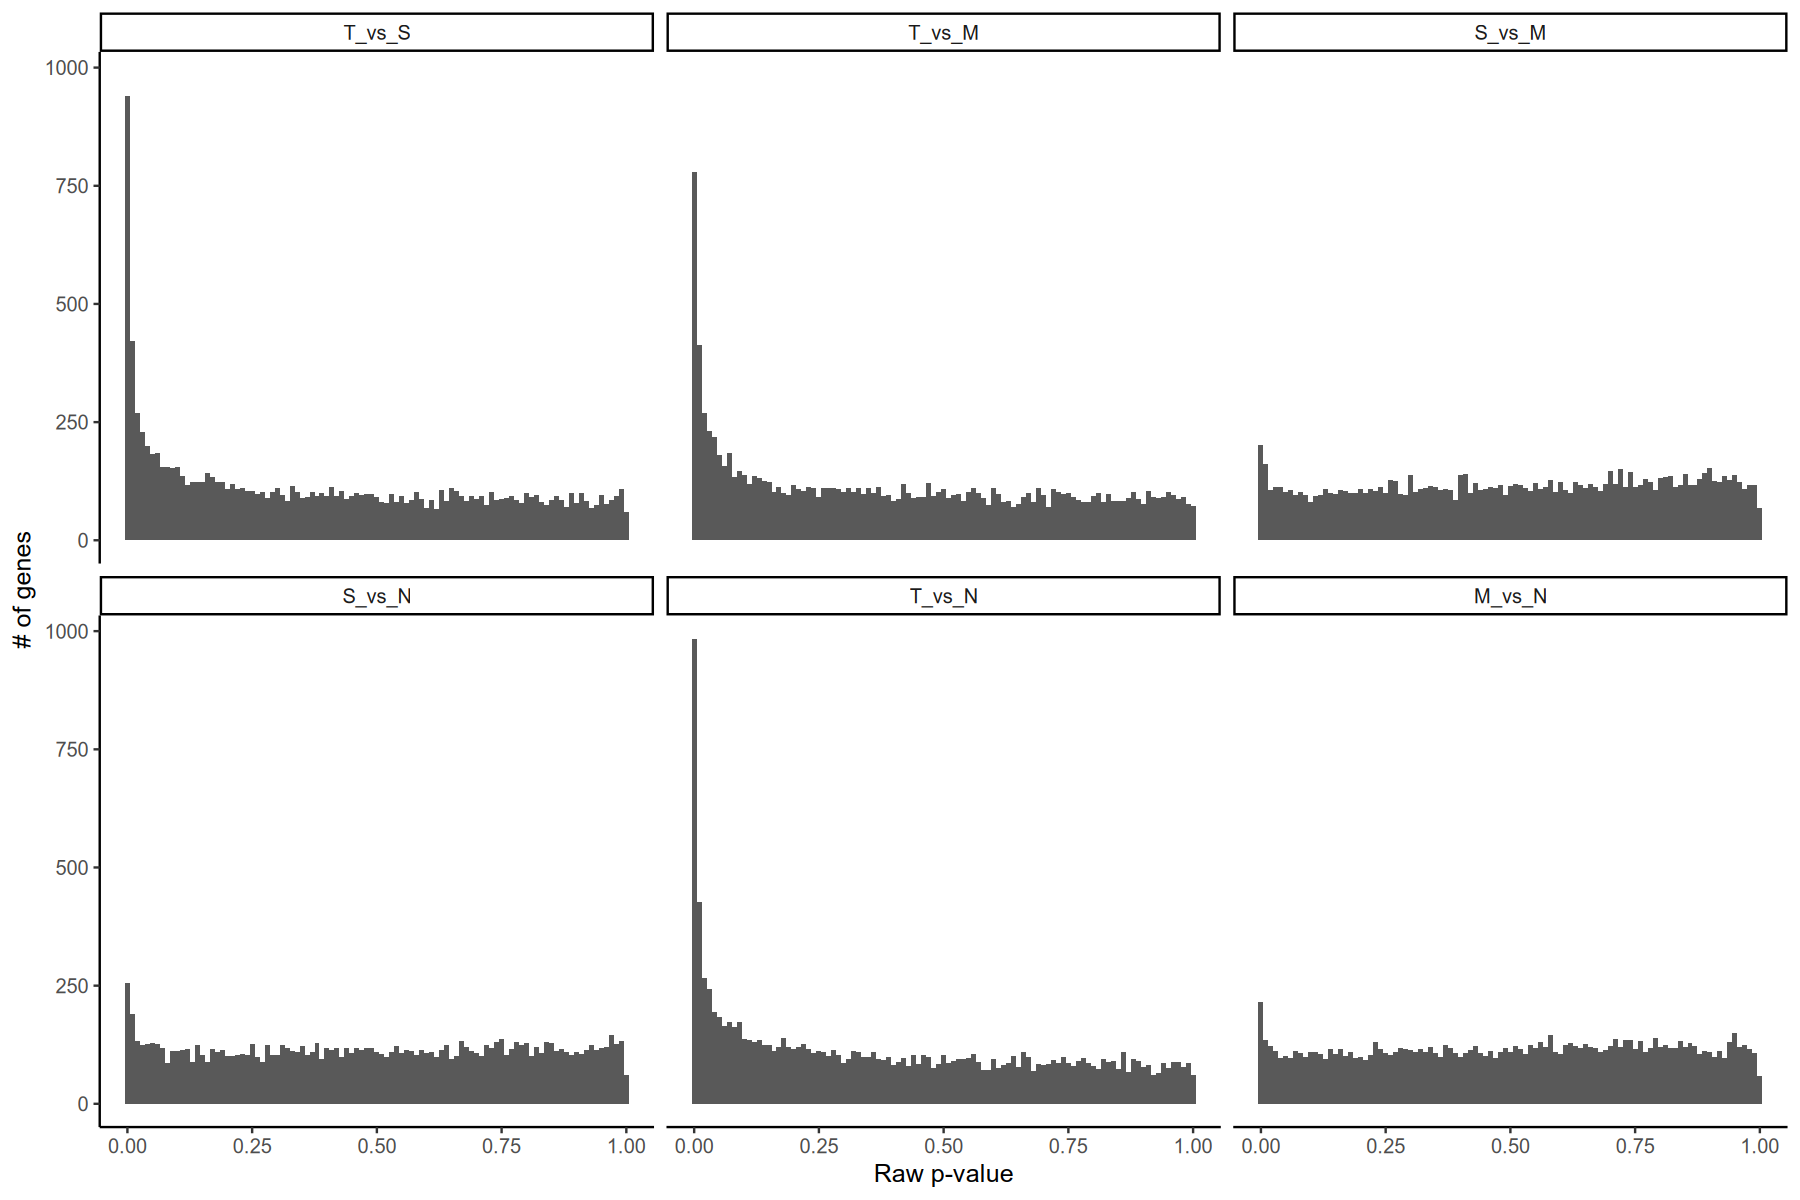

In [28]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)
ggplot(pairwise_DE_exon_pvals_df, aes(x = pvalue)) + geom_histogram(binwidth = 0.01) + facet_wrap(~ contrast, nrow = 2) + 
    xlab("Raw p-value") + ylab("# of genes") + theme_classic(base_size = 12)

In [29]:
pairwise_DE_tables_exon <- sapply(pairwise_cmps, function(x) {
    y <- strsplit(x, "_vs_")[[1]]
    g1 <- y[2]; g2 <- y[1]
    X <- pairwise_DE_exon[[x]]
    X <- X[order(X$padj), ]
    genes <- rownames(X)
    SIDs <- c(SampleInfo[Type == g1, SampleID], SampleInfo[Type == g2, SampleID])
    cnts <- cnts_exon[genes, SIDs]
    colnames(cnts) <- paste0("RawCnts_", SampleInfo[SIDs, Type, on = "SampleID"], "_", SIDs) 
    exprs <- exprs_exon[genes, SIDs]
    colnames(exprs) <- paste0("LogNorm_", SampleInfo[SIDs, Type, on = "SampleID"], "_", SIDs)
    Y <- as.data.frame(X[genes, ])
    data.table(Symbol = genes, Contrast = x, cnts, exprs, Y)
}, simplify = FALSE)

In [30]:
Tools$write_xlsx(pairwise_DE_tables_exon, file = "Result/pairwise_DE_tables_exon.xlsx", row.names = FALSE)

In [31]:
log2fc_th <- 1
padj_th <- 0.05
pairwise_DE_exon_pvalfc <- sapply(pairwise_cmps, function(x) {
    X <- pairwise_DE_tables_exon[[x]]
    data.table(
    Symbol = X[, Symbol], 
    log2FoldChange = X[, log2FoldChange], 
    log10padj = -log10(X[, padj]), 
    is_significant = !is.na(X[, padj]) & X[, padj] < padj_th & abs(X[, log2FoldChange]) > log2fc_th
    )
}, simplify = FALSE)

In [32]:
for (cmp in pairwise_cmps) {
    message(cmp)
    print(with(pairwise_DE_exon_pvalfc[[cmp]], table(ifelse(log2FoldChange > 0, "up", "dn"), is_significant)))
}

T_vs_S


    is_significant
     FALSE TRUE
  dn  5920  641
  up  5950  208


T_vs_M


    is_significant
     FALSE TRUE
  dn  5448  428
  up  6623  220


S_vs_M


    is_significant
     FALSE TRUE
  dn  5410   33
  up  7213   63


S_vs_N


    is_significant
     FALSE TRUE
  dn  6209   34
  up  6411   65


T_vs_N


    is_significant
     FALSE TRUE
  dn  5873  609
  up  5948  289


M_vs_N


    is_significant
     FALSE TRUE
  dn  7081   36
  up  5566   36


In [33]:
pairwise_siggenes_exon <- sapply(pairwise_cmps, function(x) {
    X <- pairwise_DE_exon_pvalfc[[x]]
    list(
         both = X[is_significant == TRUE, Symbol], 
         up = X[is_significant == TRUE & log2FoldChange > 0, Symbol], 
         dn = X[is_significant == TRUE & log2FoldChange < 0, Symbol]
     )
}, simplify = FALSE)

In [34]:
Tools$write_xlsx(lapply(pairwise_siggenes_exon, Tools$list_to_df), file = "Result/pairwise_siggenes_exon.xlsx", row.names = FALSE)

In [35]:
pairwise_siggenes_venn <- list(
    both = arrangeGrob(
        grobTree(venn.diagram(lapply(pairwise_siggenes_exon[c("S_vs_N", "T_vs_N", "M_vs_N")], function(x) x$both), 
            filename = NULL, cex = 1, sub.cex = 0, main.cex = 0, cat.cex = 1, 
            fill = groupColors[c("S", "T", "M")], alpha = 0.8, lwd = 0.2, 
            cat.fontfamily = "Helvetica", fontfamily = "Helvetica", margin = 0.1)), 
            top = "up+dn"),
    up = arrangeGrob(
        grobTree(venn.diagram(lapply(pairwise_siggenes_exon[c("S_vs_N", "T_vs_N", "M_vs_N")], function(x) x$up), 
            filename = NULL, cex = 1, sub.cex = 0, main.cex = 0, cat.cex = 1, 
            fill = groupColors[c("S", "T", "M")], alpha = 0.8, lwd = 0.2, 
            cat.fontfamily = "Helvetica", fontfamily = "Helvetica", margin = 0.1)), 
            top = "up"), 
    dn = arrangeGrob(
        grobTree(venn.diagram(lapply(pairwise_siggenes_exon[c("S_vs_N", "T_vs_N", "M_vs_N")], function(x) x$dn), 
            filename = NULL, cex = 1, sub.cex = 0, main.cex = 0, cat.cex = 1, 
            fill = groupColors[c("S", "T", "M")], alpha = 0.8, lwd = 0.2, 
            cat.fontfamily = "Helvetica", fontfamily = "Helvetica", margin = 0.1)), 
            top = "dn")
)

### Fig. 2D

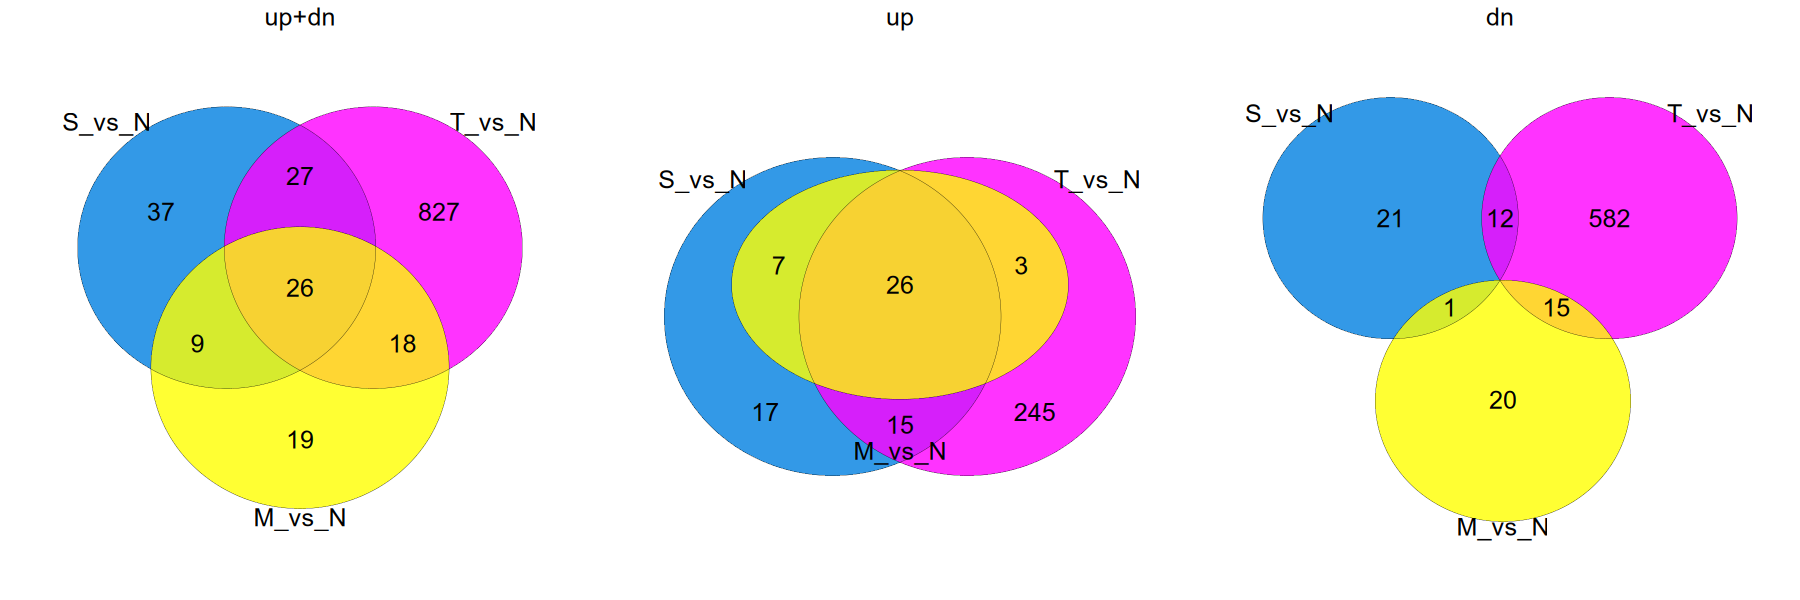

In [36]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 150)
do.call(grid.arrange, c(pairwise_siggenes_venn, list(nrow = 1, widths = rep(3, 3), heights = rep(3, 1))))

In [37]:
pairwise_DE_exon_up_shared <- Reduce(intersect, list(pairwise_siggenes_exon$T_vs_N$up, pairwise_siggenes_exon$S_vs_N$up, pairwise_siggenes_exon$M_vs_N$up))

In [38]:
str(pairwise_DE_exon_up_shared)

 chr [1:26] "Gm20324" "Ctxn3" "Mtfp1" "Twist1" "Rad54b" "Zfp607" "Grrp1" ...


In [39]:
pairwise_DE_exon_pvalfcupshared <- sapply(pairwise_cmps, function(x) {
    X <- pairwise_DE_exon_pvalfc[[x]]
    X[, is_up_shared := Symbol %in% pairwise_DE_exon_up_shared]
    X
}, simplify = FALSE)

In [40]:
figs <- NULL
for (i in seq_along(pairwise_cmps)) {
    cmp <- pairwise_cmps[[i]]
    X <- pairwise_DE_exon_pvalfcupshared[[cmp]]
    Y <- X[is_significant == TRUE]
    Z <- rbind(Y[log2FoldChange > 0][1:10], Y[log2FoldChange < 0][1:10])
    figs[[i]] <- if (cmp %in% c("T_vs_S", "T_vs_M", "S_vs_M")) { 
        ggplot(X, aes(x = log2FoldChange, y = log10padj, color = is_significant)) + 
            geom_point(size = 0.2) + 
            xlab("log2 FC") + 
            ylab("-log10 adjusted p-value") + 
            theme_classic(base_size = 12) + 
            scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) + 
            guides(color = "none") + 
            ggtitle(cmp) + 
            geom_text_repel(aes(x = log2FoldChange, y = log10padj), label = Z[, Symbol], size = 3, data = Z)
    } else {
        ggplot(X, aes(x = log2FoldChange, y = log10padj, color = is_significant)) + 
            geom_point(aes(size = is_up_shared, shape = is_up_shared)) + 
            xlab("log2 FC") + 
            ylab("-log10 adjusted p-value") + 
            theme_classic(base_size = 12) + 
            scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) + 
            scale_size_manual(values = c("FALSE" = 0.4, "TRUE" = 2)) +
            guides(color = "none", size = "none", shape = "none") + 
            ggtitle(cmp) + 
            geom_text_repel(aes(x = log2FoldChange, y = log10padj), label = Z[, Symbol], size = 3, data = Z)
    }
}

### Fig. 2C, 3A

Warning message:
“Removed 1306 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1306 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1066 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1066 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1306 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1066 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.ov

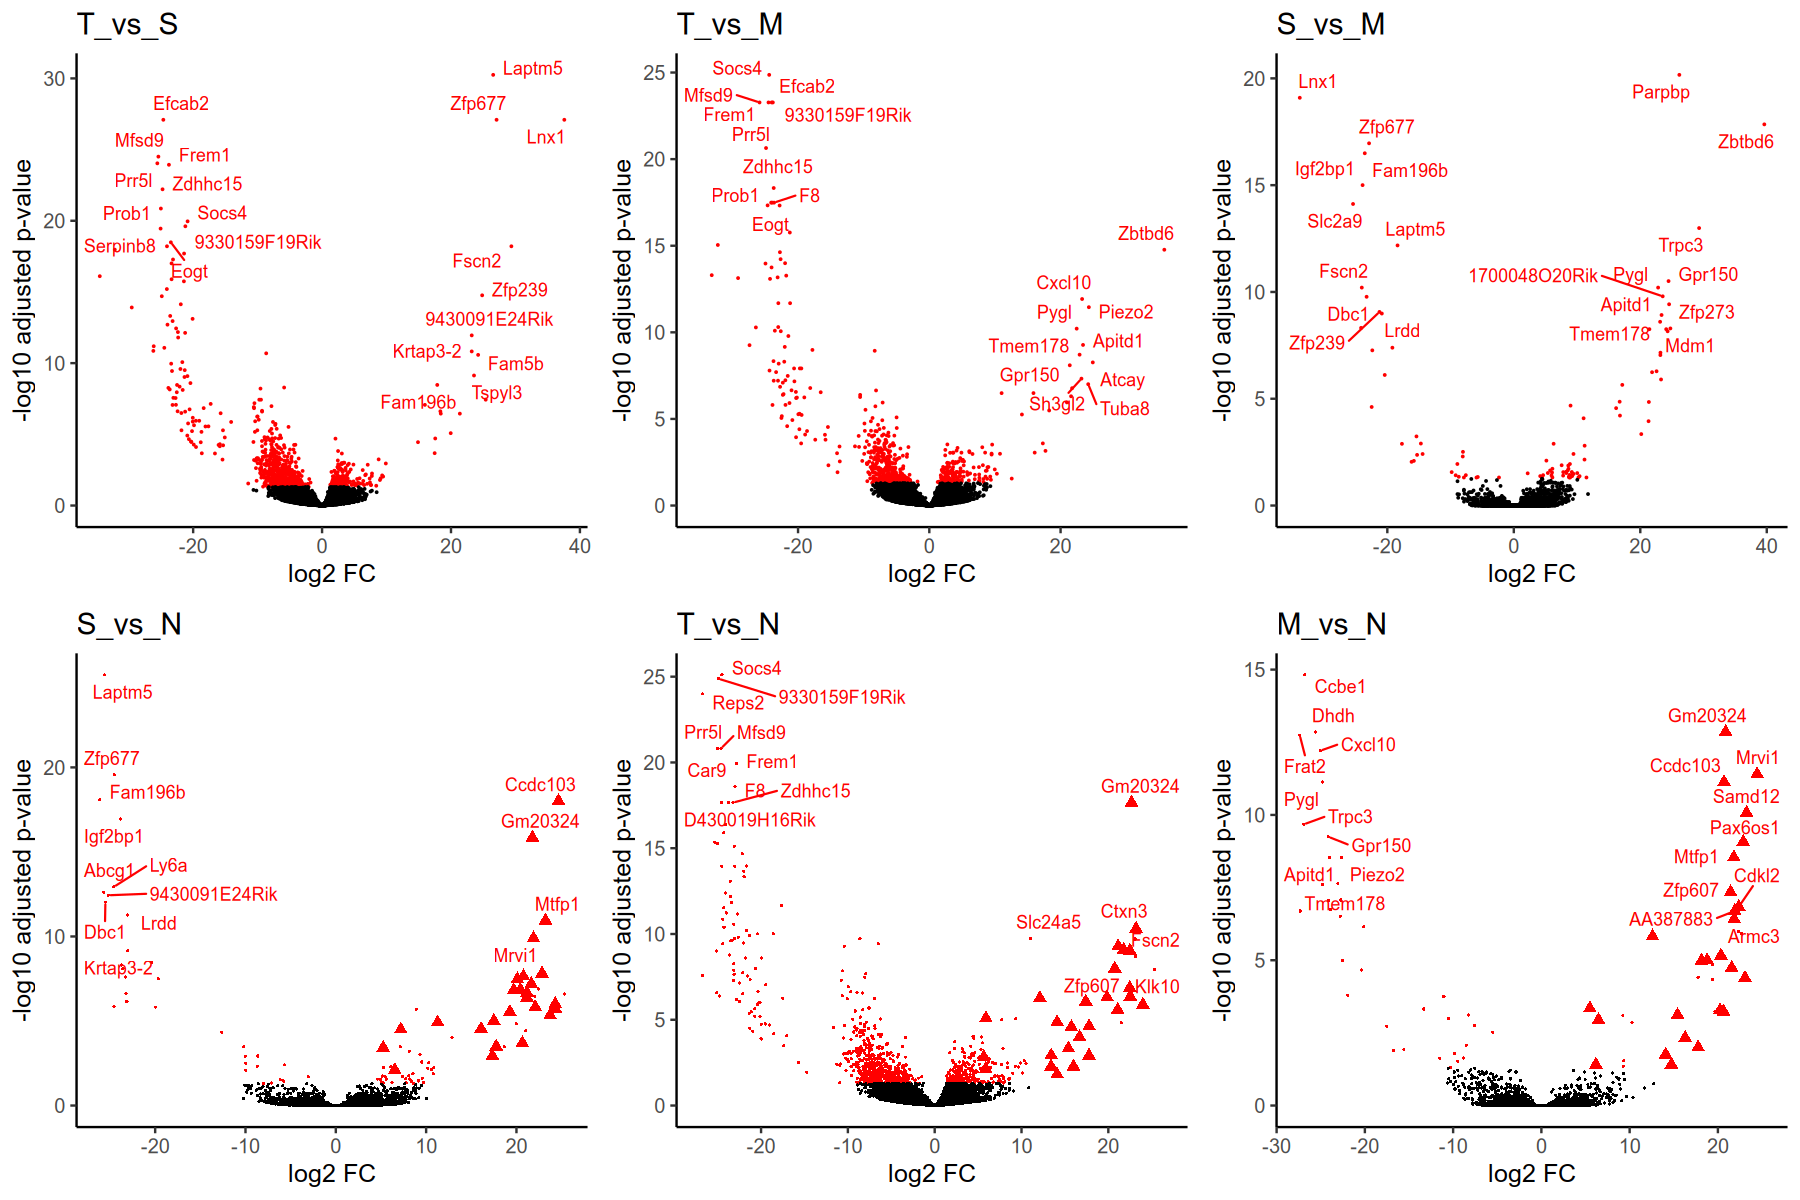

In [41]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)
do.call(grid.arrange, c(figs, ncol = 3))

In [42]:
pairwise_siggenes_exon_ego <- NULL
for (x in pairwise_cmps) {
    for (y in c("both", "up", "dn")) {
        for (z in c("MF", "BP", "CC")) {
            message(x, " ", y, " ", z)
            pairwise_siggenes_exon_ego[[x]][[y]][[z]] <- NULL
            e <- enricher(gene = pairwise_siggenes_exon[[x]][[y]], 
                pvalueCutoff = Inf,
                qvalueCutoff = Inf, 
                universe = rownames(pairwise_eset_exon), 
                pAdjustMethod = "BH", 
                minGSSize = 10, 
                maxGSSize = 500, 
                TERM2GENE = GOSymbol[[z]], 
                TERM2NAME = GOName[[z]]
            )
            pairwise_siggenes_exon_ego[[x]][[y]][[z]] <- NULL
            pairwise_siggenes_exon_ego[[x]][[y]][[z]] <- as.data.table(e)
        }
    }
}

T_vs_S both MF
T_vs_S both BP
T_vs_S both CC
T_vs_S up MF
T_vs_S up BP
T_vs_S up CC
T_vs_S dn MF
T_vs_S dn BP
T_vs_S dn CC
T_vs_M both MF
T_vs_M both BP
T_vs_M both CC
T_vs_M up MF
T_vs_M up BP
T_vs_M up CC
T_vs_M dn MF
T_vs_M dn BP
T_vs_M dn CC
S_vs_M both MF
S_vs_M both BP
S_vs_M both CC
S_vs_M up MF
S_vs_M up BP
S_vs_M up CC
S_vs_M dn MF
S_vs_M dn BP
S_vs_M dn CC
S_vs_N both MF
S_vs_N both BP
S_vs_N both CC
S_vs_N up MF
S_vs_N up BP
S_vs_N up CC
S_vs_N dn MF
S_vs_N dn BP
S_vs_N dn CC
T_vs_N both MF
T_vs_N both BP
T_vs_N both CC
T_vs_N up MF
T_vs_N up BP
T_vs_N up CC
T_vs_N dn MF
T_vs_N dn BP
T_vs_N dn CC
M_vs_N both MF
M_vs_N both BP
M_vs_N both CC
M_vs_N up MF
M_vs_N up BP
M_vs_N up CC
M_vs_N dn MF
M_vs_N dn BP
M_vs_N dn CC


In [43]:
pairwise_siggenes_exon_ego_dfs <- NULL
for (x in pairwise_cmps) {
    for (y in c("both", "up", "dn")) {
        s <- paste0(x, "_", y)
        Y <- rbindlist(lapply(c("MF", "BP", "CC"), function(o) {
            X <- pairwise_siggenes_exon_ego[[x]][[y]][[o]]
            X[, Category := o]
            X
        }))
        Y <- Y[order(Y$p.adjust), ]
        pairwise_siggenes_exon_ego_dfs[[s]] <- NULL
        pairwise_siggenes_exon_ego_dfs[[s]] <- Y
    }
}

In [44]:
filename <- "Result/pairwise_siggenes_exon_enrich_GO.xlsx"
Tools$write_xlsx(pairwise_siggenes_exon_ego_dfs, file = filename, overwrite = TRUE, row.names = FALSE)

In [45]:
pairwise_siggenes_exon_T_vs_S_up <- list(
    T_vs_S_up = pairwise_siggenes_exon$T_vs_S$up,
    S_vs_N_up = pairwise_siggenes_exon$S_vs_N$up,
    S_vs_N_dn = pairwise_siggenes_exon$S_vs_N$dn,
    T_vs_N_up = pairwise_siggenes_exon$T_vs_N$up,
    T_vs_N_dn = pairwise_siggenes_exon$T_vs_N$dn
)

pairwise_siggenes_exon_T_vs_S_dn <- list(
    T_vs_S_dn = pairwise_siggenes_exon$T_vs_S$dn,
    S_vs_N_up = pairwise_siggenes_exon$S_vs_N$up,
    S_vs_N_dn = pairwise_siggenes_exon$S_vs_N$dn,
    T_vs_N_up = pairwise_siggenes_exon$T_vs_N$up,
    T_vs_N_dn = pairwise_siggenes_exon$T_vs_N$dn
)

pairwise_siggenes_exon_T_vs_S_venn <- list(
    up = arrangeGrob(
        grobTree(venn.diagram(pairwise_siggenes_exon_T_vs_S_up, filename = NULL, cex = 1, sub.cex = 0, main.cex = 0, cat.cex = 1, 
            fill = brewer.pal(8, "Paired")[c(8, 6, 5, 4, 3)], alpha = 0.8, lwd = 0.2, cat.fontfamily = "Helvetica", fontfamily = "Helvetica", 
            margin = 0.1)), 
        top = ""), 
    dn = arrangeGrob(
        grobTree(venn.diagram(pairwise_siggenes_exon_T_vs_S_dn, filename = NULL, cex = 1, sub.cex = 0, main.cex = 0, cat.cex = 1, 
            fill = brewer.pal(8, "Paired")[c(7, 6, 5, 4, 3)], alpha = 0.8, lwd = 0.2, cat.fontfamily = "Helvetica", fontfamily = "Helvetica", 
            margin = 0.1)), 
        top = "")
)

### Fig. S2 (right)

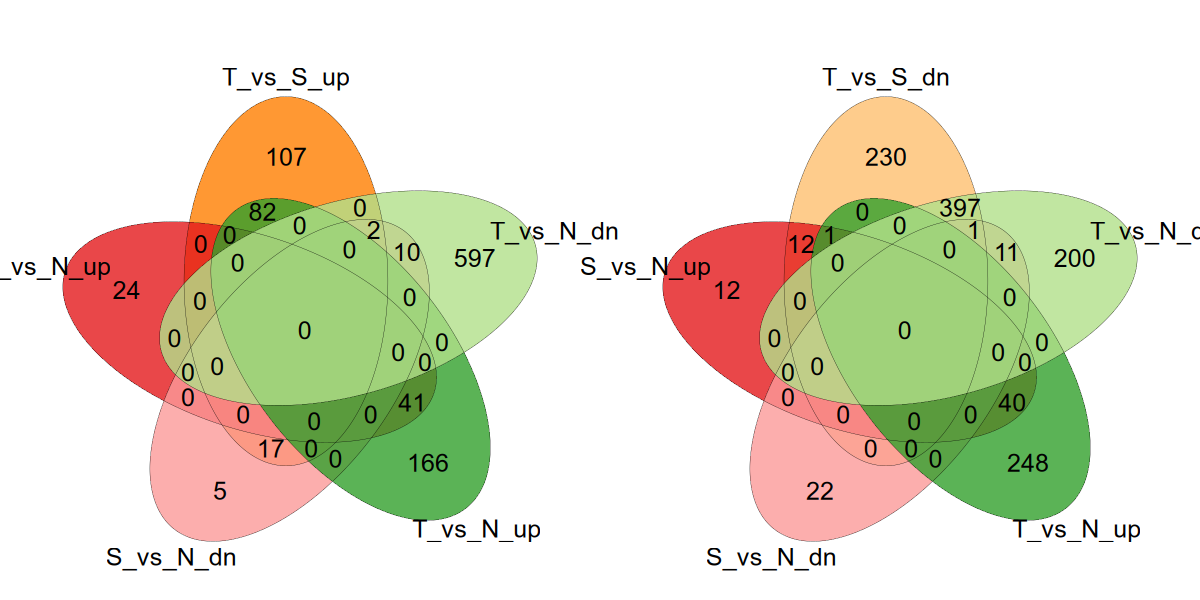

In [46]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 150)
do.call(grid.arrange, c(pairwise_siggenes_exon_T_vs_S_venn, list(nrow = 1, widths = rep(3, 2), heights = rep(3, 1))))

In [47]:
pairwise_siggenes_exon_T_vs_S_up_dt <- data.table(do.call(rbind, lapply(names(pairwise_siggenes_exon_T_vs_S_up), function(i) 
    data.frame(reg = i, gene = pairwise_siggenes_exon_T_vs_S_up[[i]], isdeg = 1, stringsAsFactors = FALSE))))
pairwise_siggenes_exon_T_vs_S_up_dt[, reg := factor(reg, levels = c("T_vs_S_up", "T_vs_N_up", "T_vs_N_dn", "S_vs_N_up", "S_vs_N_dn"))]
pairwise_siggenes_exon_T_vs_S_up_dt <- dcast(pairwise_siggenes_exon_T_vs_S_up_dt, gene ~ reg, fill = 0, value.var = "isdeg")
names(pairwise_siggenes_exon_T_vs_S_up_dt)[-1] <- c("T > S", "T > NR", "T < NR", "S > NR", "S < NR")

pairwise_siggenes_exon_T_vs_S_dn_dt <- data.table(do.call(rbind, lapply(names(pairwise_siggenes_exon_T_vs_S_dn), function(i) 
    data.frame(reg = i, gene = pairwise_siggenes_exon_T_vs_S_dn[[i]], isdeg = 1, stringsAsFactors = FALSE))))
pairwise_siggenes_exon_T_vs_S_dn_dt[, reg := factor(reg, levels = c("T_vs_S_dn", "T_vs_N_up", "T_vs_N_dn", "S_vs_N_up", "S_vs_N_dn"))]
pairwise_siggenes_exon_T_vs_S_dn_dt <- dcast(pairwise_siggenes_exon_T_vs_S_dn_dt, gene ~ reg, fill = 0, value.var = "isdeg")
names(pairwise_siggenes_exon_T_vs_S_dn_dt)[-1] <- c("T < S", "T > NR", "T < NR", "S > NR", "S < NR")

### Fig. S2 (left)

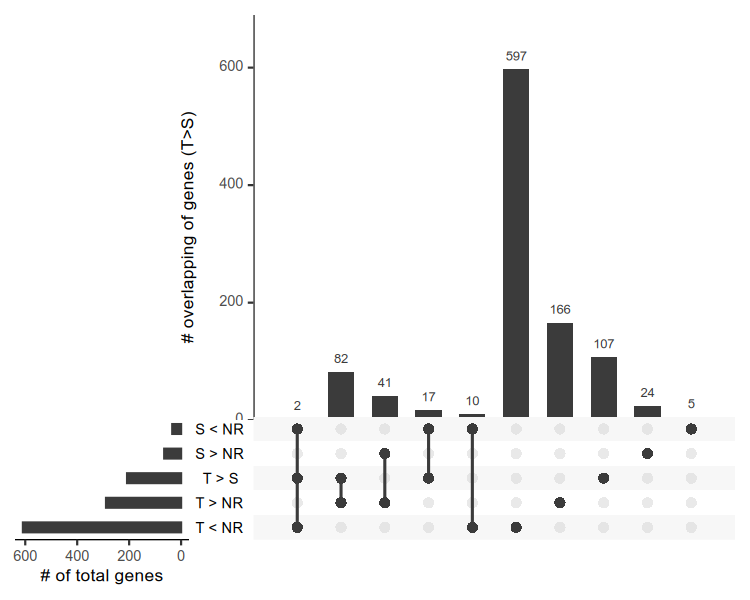

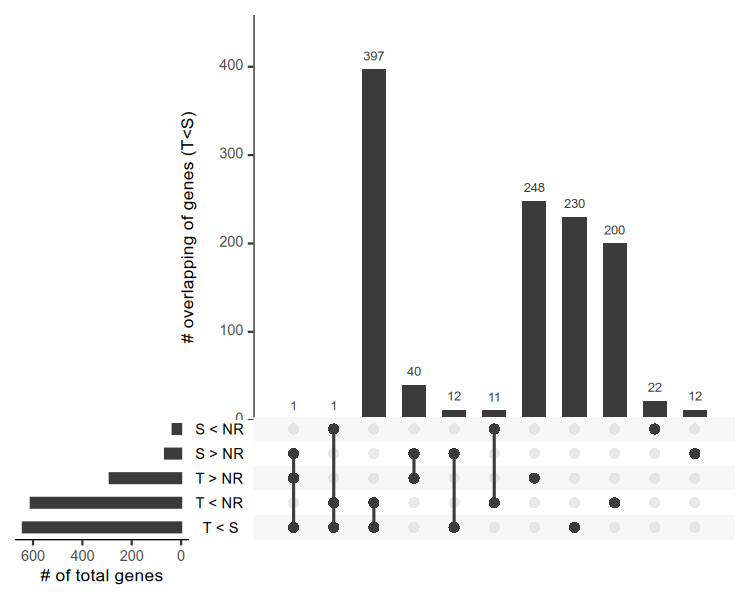

In [48]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 150)
upset(pairwise_siggenes_exon_T_vs_S_up_dt, nintersects = 32, order.by = c("freq", "degree"), decreasing = c(TRUE, TRUE), keep.order = FALSE, 
    mainbar.y.label = "# overlapping of genes (T>S)", sets.x.label = "# of total genes")
upset(pairwise_siggenes_exon_T_vs_S_dn_dt, nintersects = 32, order.by = c("freq", "degree"), decreasing = c(TRUE, TRUE), keep.order = FALSE, 
    mainbar.y.label = "# overlapping of genes (T<S)", sets.x.label = "# of total genes")

In [49]:
pairwise_siggenes_exon_T_vs_S_up_unique <- setdiff(pairwise_siggenes_exon_T_vs_S_up$T_vs_S_up, Reduce(union, pairwise_siggenes_exon_T_vs_S_up[-1]))
pairwise_siggenes_exon_T_vs_S_dn_unique <- setdiff(pairwise_siggenes_exon_T_vs_S_dn$T_vs_S_dn, Reduce(union, pairwise_siggenes_exon_T_vs_S_dn[-1]))
pairwise_siggenes_exon_T_vs_S_up_shared <- intersect(pairwise_siggenes_exon_T_vs_S_up$T_vs_S_up, union(pairwise_siggenes_exon_T_vs_S_up$T_vs_N_up, pairwise_siggenes_exon_T_vs_S_up$S_vs_N_dn))
pairwise_siggenes_exon_T_vs_S_dn_shared <- intersect(pairwise_siggenes_exon_T_vs_S_dn$T_vs_S_dn, union(pairwise_siggenes_exon_T_vs_S_dn$T_vs_N_dn, pairwise_siggenes_exon_T_vs_S_dn$S_vs_N_up))

### Fig. 3B

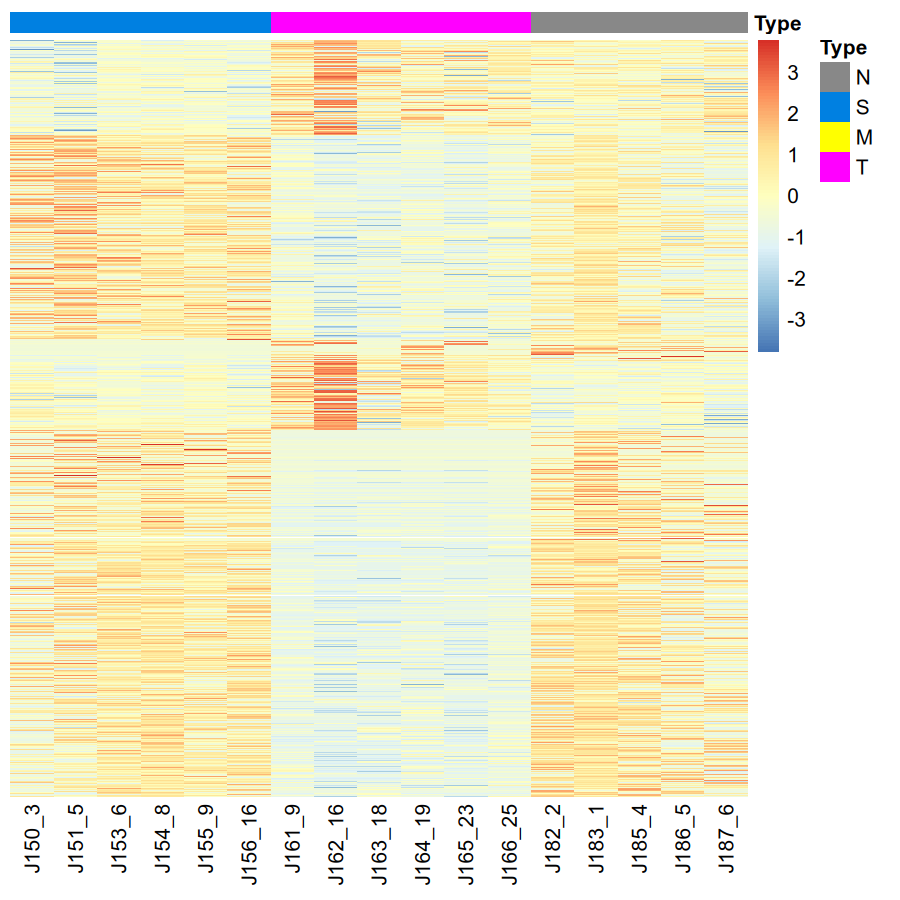

In [50]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
pheatmap(exprs_exon[c(
    pairwise_siggenes_exon_T_vs_S_up_unique, 
    pairwise_siggenes_exon_T_vs_S_dn_unique, 
    pairwise_siggenes_exon_T_vs_S_up_shared, 
    pairwise_siggenes_exon_T_vs_S_dn_shared
    ), SampleInfo[as.character(Type) != "M", SampleID]],
    cluster_cols = FALSE, 
    cluster_row = FALSE, 
    scale = "row", 
    annotation_colors = list(Type = groupColors), 
    annotation_col = with(SampleInfo, data.frame(Type, row.names = SampleID)), 
    angle_col = 90, 
    show_rownames = FALSE,
    border_color = NA
)

In [51]:
pairwise_siggenes_exon_T_vs_S_unique_shared_list <- list(
    up_unique = pairwise_siggenes_exon_T_vs_S_up_unique, 
    dn_unique = pairwise_siggenes_exon_T_vs_S_dn_unique, 
    up_shared = pairwise_siggenes_exon_T_vs_S_up_shared, 
    dn_shared = pairwise_siggenes_exon_T_vs_S_dn_shared
)

In [52]:
pairwise_siggenes_exon_T_vs_S_unique_shared_ego <- NULL
for (x in names(pairwise_siggenes_exon_T_vs_S_unique_shared_list)) {
    for (z in c("MF", "BP", "CC")) {
        message(x, " ", z)
        pairwise_siggenes_exon_T_vs_S_unique_shared_ego[[x]][[z]] <- NULL
        e <- enricher(
            gene = pairwise_siggenes_exon_T_vs_S_unique_shared_list[[x]], 
            pvalueCutoff = Inf, 
            qvalueCutoff = Inf, 
            universe = rownames(pairwise_eset_exon), 
            pAdjustMethod = "BH", 
            minGSSize = 10, 
            maxGSSize = 500, 
            TERM2GENE = GOSymbol[[z]], 
            TERM2NAME = GOName[[z]])
        pairwise_siggenes_exon_T_vs_S_unique_shared_ego[[x]][[z]] <- NULL
        pairwise_siggenes_exon_T_vs_S_unique_shared_ego[[x]][[z]] <- as.data.table(e)
    }
}

up_unique MF
up_unique BP
up_unique CC
dn_unique MF
dn_unique BP
dn_unique CC
up_shared MF
up_shared BP
up_shared CC
dn_shared MF
dn_shared BP
dn_shared CC


In [53]:
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs <- NULL
for (x in names(pairwise_siggenes_exon_T_vs_S_unique_shared_list)) {
    Y <- rbindlist(lapply(c("MF", "BP", "CC"), function(o) {
        X <- pairwise_siggenes_exon_T_vs_S_unique_shared_ego[[x]][[o]]
        X[, Category := o]
        X
    }))
    Y <- Y[order(Y$p.adjust), ]
    pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[[x]] <- NULL
    pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[[x]] <- Y
}

In [54]:
filename <- "Result/pairwise_siggenes_exon_T_vs_S_unique_shared_enrich_GO.xlsx"
Tools$write_xlsx(pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs, file = filename, overwrite = TRUE, row.names = FALSE)

In [55]:
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[["up_unique"]][, Group := "T>S unique"]
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[["dn_unique"]][, Group := "T<S unique"]
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[["up_shared"]][, Group := "T>S shared"]
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs[["dn_shared"]][, Group := "T<S shared"]

In [56]:
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_sig <- rbindlist(
    lapply(pairwise_siggenes_exon_T_vs_S_unique_shared_ego_dfs, function(X) 
        X[qvalue < 0.1, c("Group", "ID", "Description", "qvalue", "Category")]
    )
)

### Fig. 3C

In [57]:
pairwise_siggenes_exon_T_vs_S_unique_shared_ego_sig

Group,ID,Description,qvalue,Category
<chr>,<chr>,<chr>,<dbl>,<chr>
T>S unique,GO:0031305,integral component of mitochondrial inner membrane,6.854015e-02,CC
T>S unique,GO:1990904,ribonucleoprotein complex,6.854015e-02,CC
T<S unique,GO:0007059,chromosome segregation,4.169816e-05,BP
T<S unique,GO:0000070,mitotic sister chromatid segregation,1.866627e-03,BP
T<S unique,GO:0000775,"chromosome, centromeric region",2.562484e-03,CC
T<S unique,GO:0000922,spindle pole,2.562484e-03,CC
T<S unique,GO:0051301,cell division,5.576080e-03,BP
T<S unique,GO:0005694,chromosome,5.547333e-03,CC
T<S unique,GO:0005871,kinesin complex,6.912723e-03,CC


In [58]:
pairwise_exon_gsea <- NULL
for (x in pairwise_cmps) {
    pairwise_exon_gsea[[x]] <- NULL
    for (z in c("MF", "BP", "CC")) {
        message(x, " ", z)
        X <- pairwise_DE_tables_exon[[x]]
        X <- X[order(X[, stat], decreasing = TRUE), ]
        stats <- structure(X[, stat], names = X[, Symbol])
        e <- GSEA(geneList = stats, exponent = 1, pvalueCutoff = Inf, pAdjustMethod = "BH", TERM2GENE = GOSymbol[[z]], TERM2NAME = GOName[[z]])
        pairwise_exon_gsea[[x]][[z]] <- NULL
        pairwise_exon_gsea[[x]][[z]] <- e
    }
}

T_vs_S MF
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).

preparing geneSet collections...
GSEA analysis...
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...
done...
T_vs_S BP
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).

preparing geneSet collections...
GSEA analysis...
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning m

In [59]:
pairwise_exon_gsea_dfs <- NULL
for (x in pairwise_cmps) {
    Y <- rbindlist(lapply(c("MF", "BP", "CC"), function(o) {
        X <- pairwise_exon_gsea[[x]][[o]]
        X <- as.data.table(X)
        X[, Category := o]
        X
    }))
    Y <- Y[order(Y$p.adjust), ]
    pairwise_exon_gsea_dfs[[x]] <- NULL
    pairwise_exon_gsea_dfs[[x]] <- Y
}

In [60]:
filename <- "Result/pairwise_exon_gsea_GO.xlsx"
Tools$write_xlsx(pairwise_exon_gsea_dfs, file = filename, row.names = FALSE)

### Fig. 3D (inset)

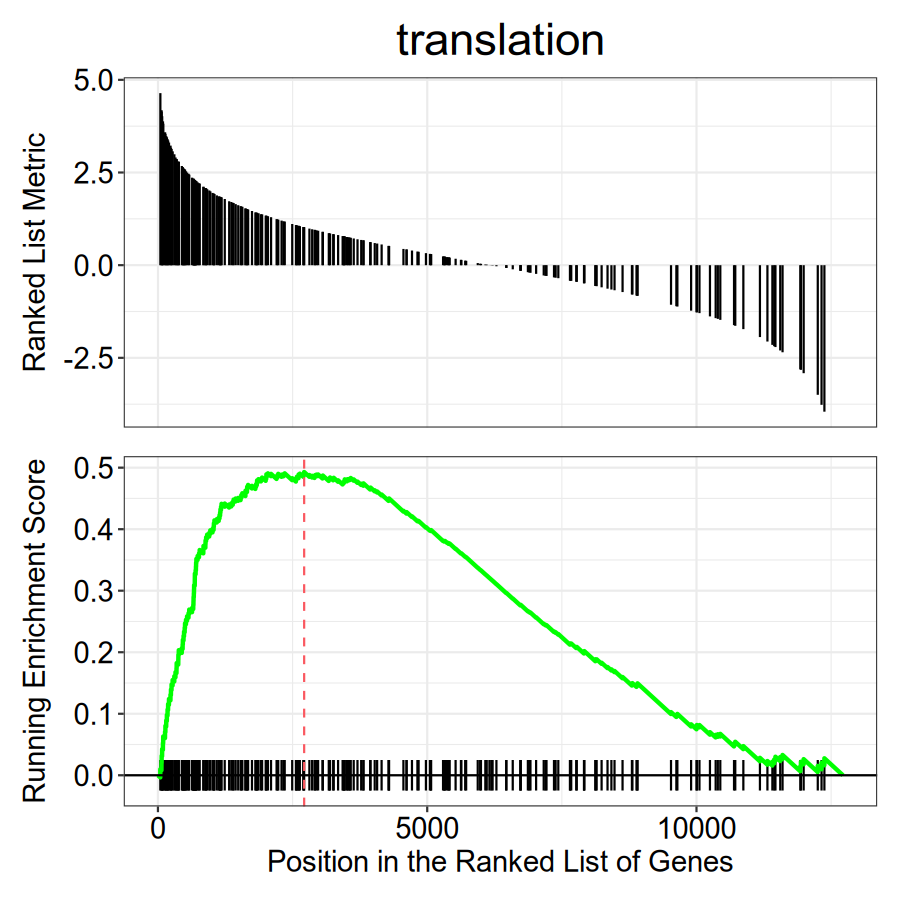

In [61]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
gseaplot(pairwise_exon_gsea[["T_vs_S"]][["BP"]], geneSetID = which(pairwise_exon_gsea[["T_vs_S"]][["BP"]][, "Description"] == "translation"), title = "translation")

In [62]:
pairwise_exon_gsea_T_vs_S <- pairwise_exon_gsea_dfs[["T_vs_S"]][qvalue < 0.1]
pairwise_exon_gsea_T_vs_S_up <- pairwise_exon_gsea_T_vs_S[NES > 0]
pairwise_exon_gsea_T_vs_S_dn <- pairwise_exon_gsea_T_vs_S[NES < 0]
xmax <- max(-log10(pairwise_exon_gsea_T_vs_S$qvalue))
xmin <- min(-log10(pairwise_exon_gsea_T_vs_S$qvalue))
pairwise_exon_gsea_T_vs_S_up <- pairwise_exon_gsea_T_vs_S_up[order(pairwise_exon_gsea_T_vs_S_up$qvalue, decreasing = TRUE)]
pairwise_exon_gsea_T_vs_S_dn <- pairwise_exon_gsea_T_vs_S_dn[order(pairwise_exon_gsea_T_vs_S_dn$qvalue)]

### Fig. 3D (top)

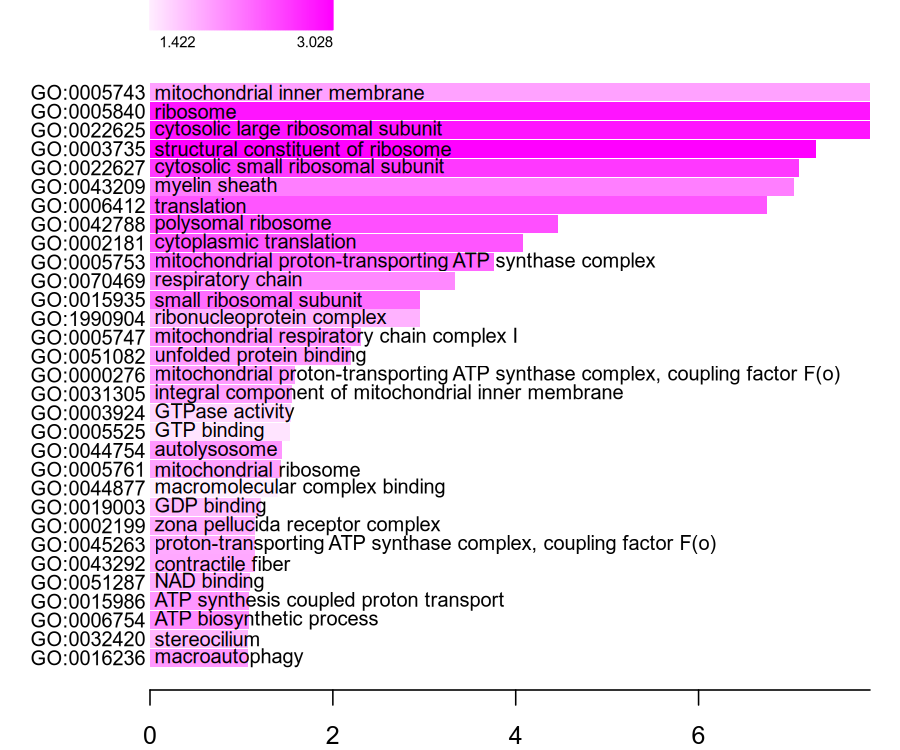

In [63]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 150)
par(mar = c(2, 5, 2, 1))
colorkey_up <- with(pairwise_exon_gsea_T_vs_S_up, colorRampPalette(c("#FFEEFF", "#FF00FF"))(256)[1 + 255 * (NES - min(NES)) / diff(range(NES))])
x <- barplot(-log10(pairwise_exon_gsea_T_vs_S_up$qvalue), col = colorkey_up, border = NA, horiz = TRUE, xlim = c(0, xmax), axes = FALSE, space = 0.05)
axis(1, at = seq(0, round(xmax), by = 2))
text(x = -0.05, y = x[, 1], labels = pairwise_exon_gsea_T_vs_S_up$ID, xpd = TRUE, adj = 1, cex = 0.8)
text(x = 0.05, y = x[, 1], labels = pairwise_exon_gsea_T_vs_S_up$Description, xpd = TRUE, adj = 0, cex = 0.8)
segments(
    x0 = seq(0, 2, length = 256), x1 = seq(0, 2, length = 256), 
    y0 = rep(par()$usr[4] + 0.05 * (par()$usr[4] - par()$usr[1]), 256), 
    y1 = rep(par()$usr[4] + 0.10 * (par()$usr[4] - par()$usr[1]), 256), 
    col = colorRampPalette(c("#FFEEFF", "#FF00FF"))(256), xpd = TRUE
)
text(x = 0.1, y = par()$usr[4] + 0.03 * (par()$usr[4] - par()$usr[1]), label = round(min(pairwise_exon_gsea_T_vs_S_up$NES), digits = 3), xpd = TRUE, adj = 0, cex = 0.6)
text(x = 2, y = par()$usr[4] + 0.03 * (par()$usr[4] - par()$usr[1]), label = round(max(pairwise_exon_gsea_T_vs_S_up$NES), digits = 3), xpd = TRUE, adj = 1, cex = 0.6)

### Fig. 3D (bottom)

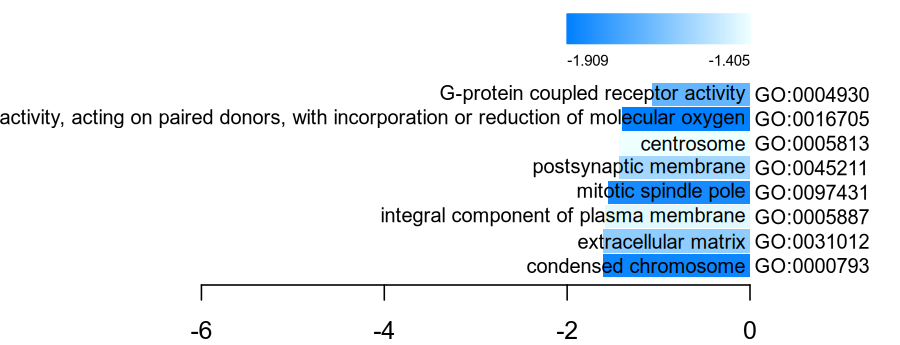

In [64]:
options(repr.plot.width = 6, repr.plot.height = 2.3, repr.plot.res = 150)
par(mar = c(2, 1, 2.5, 5))
colorkey_dn <- with(pairwise_exon_gsea_T_vs_S_dn, colorRampPalette(c("#EEFFFF", "#0080FF"))(256)[1 + 255 * (max(NES) - NES) / diff(range(NES))])
x <- barplot(log10(pairwise_exon_gsea_T_vs_S_dn$qvalue), col = colorkey_dn, border = NA, horiz = TRUE, xlim = c(-xmax, 0), axes = FALSE, space = 0.05)
axis(1)
text(x = 0.05, y = x[, 1], labels = pairwise_exon_gsea_T_vs_S_dn$ID, xpd = TRUE, adj = 0, cex = 0.8)
text(x = -0.05, y = x[, 1], labels = pairwise_exon_gsea_T_vs_S_dn$Description, xpd = TRUE, adj = 1, cex = 0.8)
segments(
    x0 = seq(-2, 0, length = 256), x1 = seq(-2, 0, length = 256), 
    y0 = rep(par()$usr[4] + 0.15 * (par()$usr[4] - par()$usr[3]), 256), 
    y1 = rep(par()$usr[4] + 0.29 * (par()$usr[4] - par()$usr[3]), 256), 
    col = rev(colorRampPalette(c("#EEFFFF", "#0080FF"))(256)), xpd = TRUE
)
text(x = -0.45, y = par()$usr[4] + 0.07 * (par()$usr[4] - par()$usr[3]), label = round(max(pairwise_exon_gsea_T_vs_S_dn$NES), digits = 3), xpd = TRUE, adj = 0, cex = 0.6)
text(x = -1.55, y = par()$usr[4] + 0.07 * (par()$usr[4] - par()$usr[3]), label = round(min(pairwise_exon_gsea_T_vs_S_dn$NES), digits = 3), xpd = TRUE, adj = 1, cex = 0.6)

In [65]:
pairwise_exon_gsea_M_vs_N <- pairwise_exon_gsea_dfs[["M_vs_N"]][qvalue < 0.1]
pairwise_exon_gsea_M_vs_N_up <- pairwise_exon_gsea_M_vs_N[NES > 0]
pairwise_exon_gsea_M_vs_N_dn <- pairwise_exon_gsea_M_vs_N[NES < 0]
xmax <- max(-log10(pairwise_exon_gsea_M_vs_N$qvalue))
xmin <- min(-log10(pairwise_exon_gsea_M_vs_N$qvalue))
pairwise_exon_gsea_M_vs_N_up <- pairwise_exon_gsea_M_vs_N_up[order(pairwise_exon_gsea_M_vs_N_up$qvalue, decreasing = TRUE)]
pairwise_exon_gsea_M_vs_N_dn <- pairwise_exon_gsea_M_vs_N_dn[order(pairwise_exon_gsea_M_vs_N_dn$qvalue)]

### Fig. 2F (top)

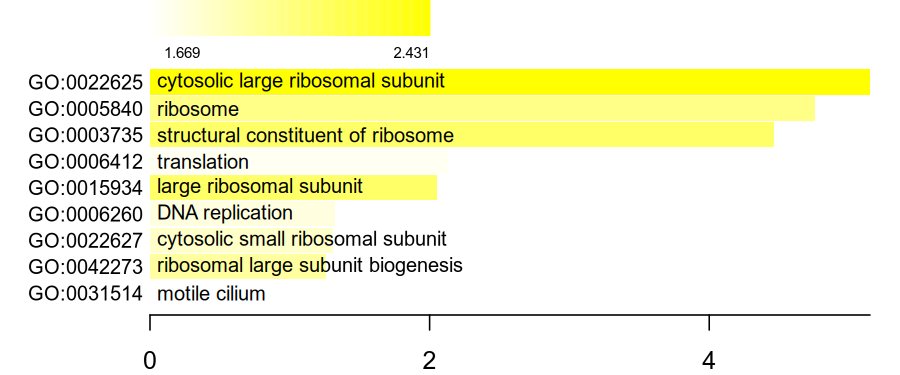

In [66]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 150)
par(mar = c(2, 5, 2, 1))
colorkey_up <- with(pairwise_exon_gsea_M_vs_N_up, rev(colorRampPalette(c("#FFFF00", "#FFFFFF"))(256))[1 + 255 * (NES - min(NES)) / diff(range(NES))])
x <- barplot(-log10(pairwise_exon_gsea_M_vs_N_up$qvalue), col = colorkey_up, border = NA, horiz = TRUE, xlim = c(0, xmax), axes = FALSE, space = 0.05)
axis(1, at = seq(0, round(xmax) + 1, by = 2))
text(x = -0.05, y = x[, 1], labels = pairwise_exon_gsea_M_vs_N_up$ID, xpd = TRUE, adj = 1, cex = 0.8)
text(x = 0.05, y = x[, 1], labels = pairwise_exon_gsea_M_vs_N_up$Description, xpd = TRUE, adj = 0, cex = 0.8)
segments(
    x0 = seq(0, 2, length = 256), x1 = seq(0, 2, length = 256), 
    y0 = rep(par()$usr[4] + 0.1 * (par()$usr[4] - par()$usr[1]), 256), 
    y1 = rep(par()$usr[4] + 0.44 * (par()$usr[4] - par()$usr[1]), 256), 
    col = rev(colorRampPalette(c("#FFFF00", "#FFFFFF"))(256)), 
    xpd = TRUE
)
text(x = 0.1, y = par()$usr[4] + 0.03 * (par()$usr[4] - par()$usr[1]), label = round(min(pairwise_exon_gsea_M_vs_N_up$NES), digits = 3), xpd = TRUE, adj = 0, cex = 0.6)
text(x = 2, y = par()$usr[4] + 0.03 * (par()$usr[4] - par()$usr[1]), label = round(max(pairwise_exon_gsea_M_vs_N_up$NES), digits = 3), xpd = TRUE, adj = 1, cex = 0.6)

### Fig. 2F (bottom)

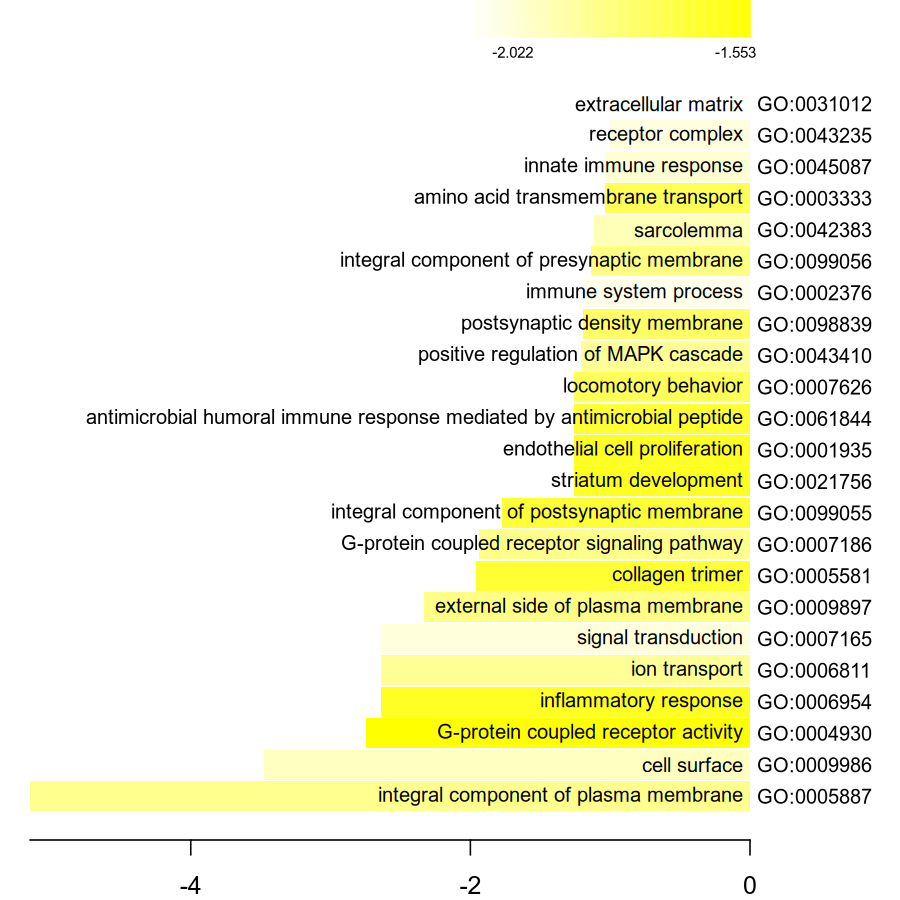

In [67]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 150)
par(mar = c(2, 1, 2, 5))
colorkey_dn <- with(pairwise_exon_gsea_M_vs_N_dn, rev(colorRampPalette(c("#FFFF00", "#FFFFFF"))(256))[1 + 255 * (max(NES) - NES) / diff(range(NES))])
x <- barplot(log10(pairwise_exon_gsea_M_vs_N_dn$qvalue), col = colorkey_dn, border = NA, horiz = TRUE, xlim = c(-xmax, 0), axes = FALSE, space = 0.05)
axis(1, at = seq(-round(xmax)-1, 0, by = 2))
text(x = 0.05, y = x[, 1], labels = pairwise_exon_gsea_M_vs_N_dn$ID, xpd = TRUE, adj = 0, cex = 0.8)
text(x = -0.05, y = x[, 1], labels = pairwise_exon_gsea_M_vs_N_dn$Description, xpd = TRUE, adj = 1, cex = 0.8)
segments(
    x0 = seq(-2, 0, length = 256), x1 = seq(-2, 0, length = 256), 
    y0 = rep(par()$usr[4] + 0.03 * (par()$usr[4] - par()$usr[3]), 256), 
    y1 = rep(par()$usr[4] + 0.10 * (par()$usr[4] - par()$usr[3]), 256), 
    col = rev(colorRampPalette(c("#FFFF00", "#FFFFFF"))(256)), 
    xpd = TRUE
)
text(x = -0.25, y = par()$usr[4] + 0.01 * (par()$usr[4] - par()$usr[3]), label = round(max(pairwise_exon_gsea_M_vs_N_dn$NES), digits = 3), xpd = TRUE, adj = 0, cex = 0.6)
text(x = -1.55, y = par()$usr[4] + 0.01 * (par()$usr[4] - par()$usr[3]), label = round(min(pairwise_exon_gsea_M_vs_N_dn$NES), digits = 3), xpd = TRUE, adj = 1, cex = 0.6)

In [68]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] pheatmap_1.0.12             UpSetR_1.4.0               
 [3] RColorBrewer_1.1-3          clusterProfiler_4.12.6     
 [5] VennDiagram_1.7.3      